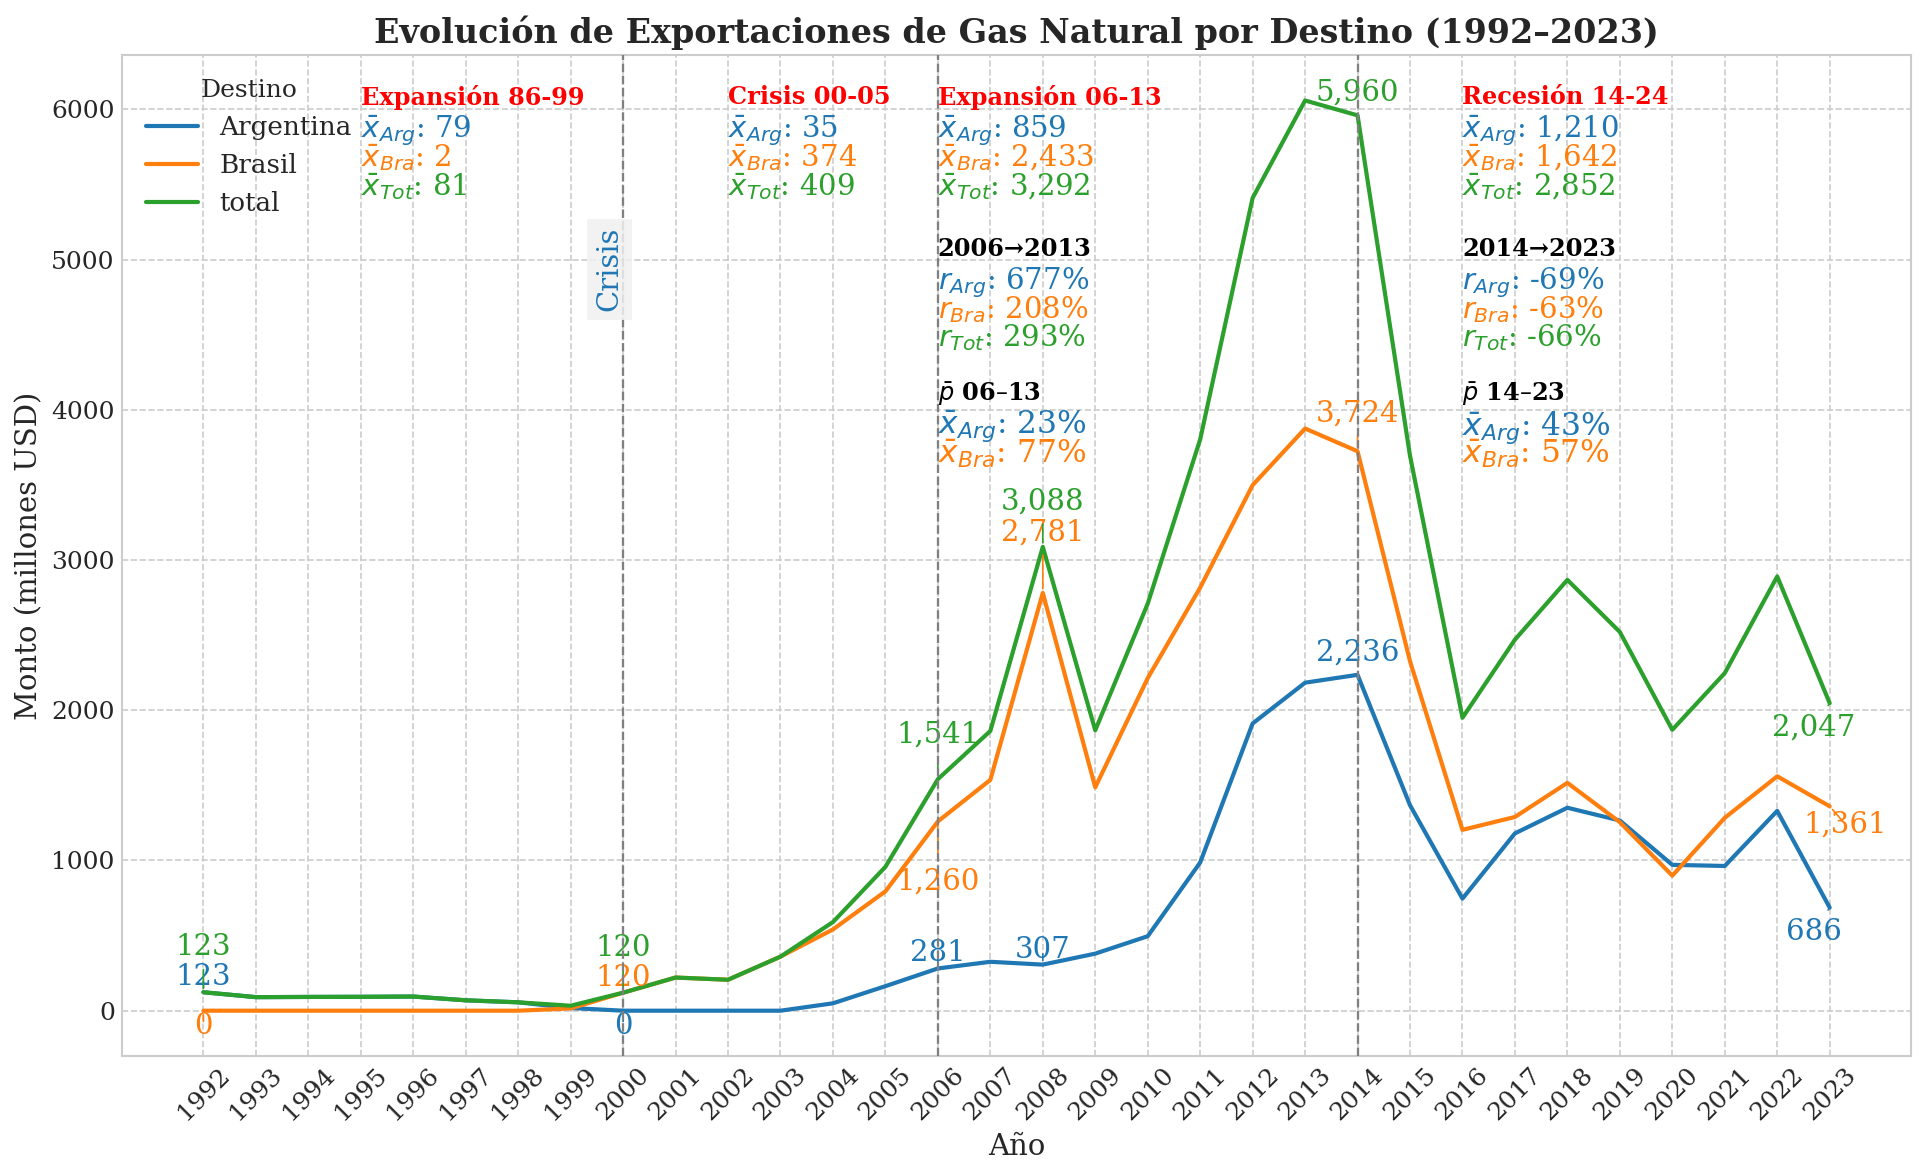

In [2]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import sqlite3, os
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_participation_cycle_boxes, add_cycle_means_multi, add_hitos,
    add_period_growth_annotations_multi, add_year_value_annotations
)
# ── 1. Configuración general ─────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(output_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16,  "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150,     "savefig.bbox": "tight"
})
periods = {
    "Expansión 56-69":   slice(1956, 1969),
    "Recesión 70-81":    slice(1970, 1981),
    "Expansión 86-99":   slice(1986, 1999),
    "Crisis 00-05":      slice(2000, 2005),
    "Expansión 06-13":   slice(2006, 2013),
    "Recesión 14-24":    slice(2014, 2024),
}
periodos_growth = [
    (2006, 2013),  # Expansión 06-13
    (2014, 2023),  # Recesión 14-24
]

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_raw = pd.read_sql(
        "SELECT año, destino, monto FROM exportacion_gas_natural_contratos",
        conn
    )
    

# 2.1 Agrupar por destino
df = (df_raw.groupby(['año', 'destino'])['monto']
                .sum()
                .unstack(fill_value=0)
                .sort_index())
df['total']=df.sum(axis=1)

#estadisticas
cycle_stats = {
    name: df.loc[period].mean().to_dict()
    for name, period in periods.items()
}

componentes = [
    ("Argentina", "Argentina"),
    ("Brasil", "Brasil"),
    ("total", "Total"),
]
colors = {
    "Argentina": "#1f77b4",  # azul
    "Brasil":    "#ff7f0e",  # naranja
    "total":     "#2ca02c",  # verde
}
abbr_map = {
    "Argentina": "Arg",
    "Brasil":    "Bra",
    "total":     "Tot",
}
# ── 3. Hitos y anotaciones ──────────────────────────────────────────
hitos_v = {2000:"Crisis", 2006:"Expansion", 2014:"Recesion"}
anot_years = [1992, 2000, 2006, 2008, 2014, 2023]
annotation_offsets = {
    "Argentina": {
        1992: (0,   100),
        2000: (0,  -100),
        2006: (0,   100),
        2008: (0,  100),
        2014: (0,   150),
        2023: (-0.3,   -160),
    },
    "Brasil": {
        1992: ( 0,   -100),
        2000: ( 0,   100),
        2006: ( 0,  -400),
        2008: ( 0,  400),
        2014: ( 0,   250),
        2023: ( 0.3,  -120),
    },
    "total": {
        1992: (0,   300),
        2000: (0,  300),
        2006: (0,   300),
        2008: (0,  300),
        2014: (0,   150),
        2023: (-0.3,   -160),
    },
}
medias_offset = {
    "Expansión 86-99": (1995, 0.97),
    "Expansión 06-13": (2006, 0.97),
    "Crisis 00-05":    (2002, 0.97),
    "Recesión 14-24":  (2016, 0.97),
}
growth_offsets = {
    "2006-2013": (2006, 0.81),  
    "2014-2023": (2016, 0.81),        
}
hitos_offset={}
participation_offsets = {
    "2006-2013": (2006, 0.66),
    "2014-2023": (2016, 0.66),
}
# ── 4. Gráfico ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13, 8))
cmap = plt.get_cmap("tab10")

for col, _ in componentes:
    ax.plot(df.index, df[col],
            label=col, color=colors[col])
#hitos
add_hitos(ax, df.index, hitos_v, hitos_offset)

# ── 6. Anotaciones en años clave ─────────────────────────────────────

columnas=[col for col, _ in componentes]
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(ax, cycle_stats, medias_offset, abbr_map, colors, line_spacing)

add_period_growth_annotations_multi(
    ax,
    df,
    periodos_growth,
    columnas,
    growth_offsets,
    colors,
    abbr_map,
    fmt="{vi}→{vf}: {tasa}%",
)
add_year_value_annotations(ax, df, anot_years, columnas, annotation_offsets, colors,arrow_lw=0.8)

add_participation_cycle_boxes(
    ax,
    df,
    periodos_growth,
    ["Argentina", "Brasil"],
    "total",
    participation_offsets,
    abbr_map,
    colors,
)


# ── 7. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"Evolución de Exportaciones de Gas Natural por Destino ({df.index[0]}–{df.index[-1]})",
             fontweight="bold")
ax.set_xlabel("Año")
ax.set_ylabel("Monto (millones USD)")
ax.set_xticks(df.index[::max(1, len(df)//31)])
ax.tick_params(axis="x", rotation=45)

# leyenda solo de las lineplots
handles = [h for h in ax.get_lines() if not h.get_label().startswith('_')]
ax.legend(handles, [h.get_label() for h in handles],
          title="Destino", loc="upper left", fontsize=12.6)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "gas_natural_por_destino.png"), dpi=300)
plt.show()

